# ESPCN (Efficient Sub-Pixel Convolution Neural Network)

## Preprocess

In [1]:
import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_reduce 
plt.style.use('dark_background')

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
base_path = 'C:\img_align_celeba'
img_base_path = os.path.join(base_path, 'img_align_celeba')
target_img_path = os.path.join(base_path, 'processed')

In [3]:
eval_list_raw = np.loadtxt(os.path.join(base_path, 'list_eval_partition.csv'), dtype=str, delimiter=',', skiprows=1)
eval_list = np.append(eval_list_raw[:18000], eval_list_raw[162772:163772], axis = 0)
eval_list = np.append(eval_list, eval_list_raw[182639:183639], axis = 0)

print(eval_list[0])
print(len(eval_list))

['000001.jpg' '0']
20000


178 45
(178, 178, 3) (178, 178, 3)


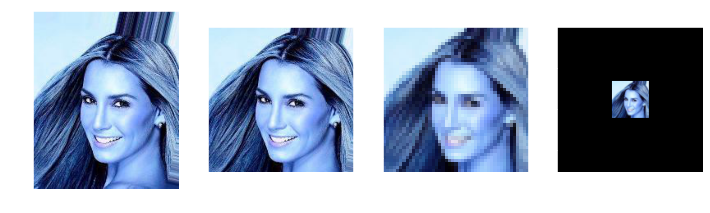

In [4]:
img_sample = cv2.imread(os.path.join(img_base_path, eval_list[0][0]))

h, w, _ = img_sample.shape

crop_sample = img_sample[int((h-w)/2):int(-(h-w)/2), :]
resized_sample = pyramid_reduce(crop_sample, downscale=4)
print(crop_sample.shape[0],resized_sample.shape[0] )

pad = int((crop_sample.shape[0] - resized_sample.shape[0]) / 2 )

padded_sample = cv2.copyMakeBorder(resized_sample, top=pad+1, bottom=pad, left=pad+1, right=pad, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

print(crop_sample.shape, padded_sample.shape)

plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.imshow(img_sample)
plt.subplot(1, 4, 2)
plt.imshow(crop_sample)
plt.subplot(1, 4, 3)
plt.imshow(resized_sample)
plt.subplot(1, 4, 4)
plt.imshow(padded_sample)

In [5]:
downscale = 4
n_train = 18000
n_val = 1000
n_test = 1000

for i, e in enumerate(eval_list):
    filename, ext = os.path.splitext(e[0])
    
    img_path = os.path.join(img_base_path, e[0])
    
    img = cv2.imread(img_path)
    
    h, w, _ = img.shape
    
    crop = img[int((h-w)/2):int(-(h-w)/2), :]
    crop = cv2.resize(crop, dsize=(176, 176))
    resized = pyramid_reduce(crop, downscale=downscale)

    norm = cv2.normalize(crop.astype(np.float64), None, 0, 1, cv2.NORM_MINMAX)
    
    if int(e[1]) == 0:
        np.save(os.path.join(target_img_path, 'x_train', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_train', filename + '.npy'), norm)
    elif int(e[1]) == 1:
        np.save(os.path.join(target_img_path, 'x_val', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_val', filename + '.npy'), norm)
    elif int(e[1]) == 2:
        np.save(os.path.join(target_img_path, 'x_test', filename + '.npy'), resized)
        np.save(os.path.join(target_img_path, 'y_test', filename + '.npy'), norm)


## Train

In [6]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

Using TensorFlow backend.


In [7]:
base_path = 'C:\img_align_celeba\processed'

x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))

print(len(x_train_list), len(x_val_list))
print(x_train_list[0])

18000 1000
C:\img_align_celeba\processed\x_train\000001.npy


(44, 44, 3) (44, 44, 3)


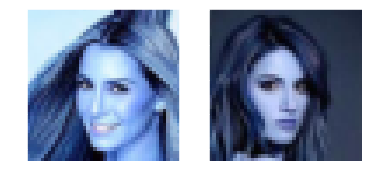

In [8]:
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

In [9]:
train_gen = DataGenerator(list_IDs=x_train_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, labels=None, batch_size=16, dim=(44,44), n_channels=3, n_classes=None, shuffle=False)

In [10]:
print(x_train_list)

['C:\\img_align_celeba\\processed\\x_train\\000001.npy', 'C:\\img_align_celeba\\processed\\x_train\\000002.npy', 'C:\\img_align_celeba\\processed\\x_train\\000003.npy', 'C:\\img_align_celeba\\processed\\x_train\\000004.npy', 'C:\\img_align_celeba\\processed\\x_train\\000005.npy', 'C:\\img_align_celeba\\processed\\x_train\\000006.npy', 'C:\\img_align_celeba\\processed\\x_train\\000007.npy', 'C:\\img_align_celeba\\processed\\x_train\\000008.npy', 'C:\\img_align_celeba\\processed\\x_train\\000009.npy', 'C:\\img_align_celeba\\processed\\x_train\\000010.npy', 'C:\\img_align_celeba\\processed\\x_train\\000011.npy', 'C:\\img_align_celeba\\processed\\x_train\\000012.npy', 'C:\\img_align_celeba\\processed\\x_train\\000013.npy', 'C:\\img_align_celeba\\processed\\x_train\\000014.npy', 'C:\\img_align_celeba\\processed\\x_train\\000015.npy', 'C:\\img_align_celeba\\processed\\x_train\\000016.npy', 'C:\\img_align_celeba\\processed\\x_train\\000017.npy', 'C:\\img_align_celeba\\processed\\x_train\\0000

In [11]:
print('C:\\img_align_celeba\\processed\\x_train\\162773.npy' in x_train_list, 
      'C:\\img_align_celeba\\processed\\x_val\\162773.npy' in x_val_list,
      'C:\\img_align_celeba\\processed\\x_train\\000001.npy' in x_train_list)

False True True


In [12]:
splited = x_train_list[0].split('\\')
print(splited)

path = 'C:\img_align_celeba\processed\y_train\\' + splited[-1]
print(path)

['C:', 'img_align_celeba', 'processed', 'x_train', '000001.npy']
C:\img_align_celeba\processed\y_train\000001.npy


In [13]:
print(len(train_gen))

1125


In [15]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 44, 44, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel_2 (Subpixel)        (None, 176, 176, 3)       6960      
_________________________________________________________________
activation_2 (Activation)    (None, 176, 176, 3)       0         
Total para

In [16]:
history = model.fit_generator(train_gen, validation_data=val_gen, epochs=10, verbose=1, callbacks=[
    ModelCheckpoint(r'C:\img_align_celeba\models\model.h5',
                    monitor='val_loss', 
                    verbose=1,
                    save_best_only=True)
])



Epoch 1/10
1125/1125 [==============================] - 16602s 15s/step - loss: 0.0066 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00232, saving model to C:\img_align_celeba\models\model.h5
Epoch 2/10
1125/1125 [==============================] - 36464s 32s/step - loss: 0.0023 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00232 to 0.00195, saving model to C:\img_align_celeba\models\model.h5
Epoch 3/10
1125/1125 [==============================] - 3354s 3s/step - loss: 0.0021 - val_loss: 0.0020

Epoch 00003: val_loss did not improve from 0.00195
Epoch 4/10
1125/1125 [==============================] - 1675s 1s/step - loss: 0.0019 - val_loss: 0.0018

Epoch 00004: val_loss improved from 0.00195 to 0.00179, saving model to C:\img_align_celeba\models\model.h5
Epoch 5/10
1125/1125 [==============================] - 1618s 1s/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00005: val_loss did not improve from 0.00179
Epoch 6/10
1125/1125 [=========================

fit generator : https://keras.io/ko/models/sequential/

In [17]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

1000 1000
C:\img_align_celeba\processed\x_test\182640.npy


(44, 44, 3) (176, 176, 3)


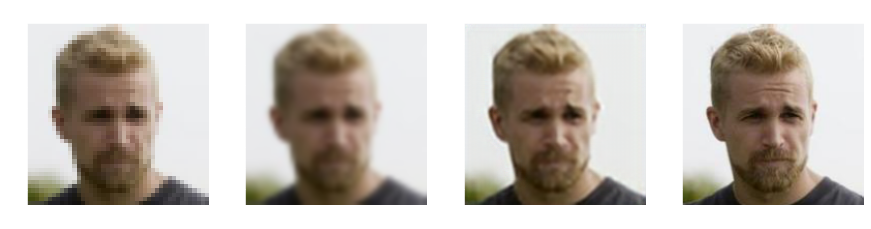

In [18]:
test_idx = 21

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)

plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)

plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)

plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)